In [1]:
import pandas as pd
import logomaker
import numpy as np
import matplotlib.pyplot as plt
import logomaker
import pickle
import torch
from scipy.stats import pearsonr
import seaborn as sns

In [ ]:
with open("/valid_denoised_neo.pkl","wb") as f:
    pickle.dump(denoised_data, f)
with open("/valid_epitope_neo.pkl","wb") as f:
    pickle.dump(epitope_list, f)
with open("/valid_original_tcr_neo.pkl","wb") as f:
    pickle.dump(original_tcr_list, f)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
codons = {      'GCC': 'A', 'TGC': 'C', 'GAC': 'D', 'GAG': 'E',
                'TTC': 'F', 'GGC': 'G', 'CAC': 'H', 'ATC': 'I',
                'AAG': 'K', 'CTG': 'L', 'ATG': 'M', 'AAC': 'N',
                'CCC': 'P', 'CAG': 'Q', 'AGA': 'R', 'AGC': 'S',
                'ACC': 'T', 'GTG': 'V', 'TGG': 'W', 'TAC': 'Y', 'TGA': '*', 'AAA':"**"
}

In [9]:
## nuclei acid -> amino
def acid_to_amino(data):
    
    sequences = data.idxmax(axis=1).str.cat()
    seq = [codons[sequences[i:i+3]] for i in range(0, len(sequences), 3)]
    
    # amino_acids 
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    
    one_hot_matrix = np.zeros((len(seq), len(amino_acids)))
    one_hot_matrix_df = pd.DataFrame(one_hot_matrix, columns= amino_acids)
    
    
    for i, aa in enumerate(seq):
        one_hot_matrix_df.loc[i, aa] = 1

    original_df= pd.DataFrame(one_hot_matrix, columns=amino_acids)
    
    return original_df

In [10]:
acid_num = []
for i in range(0, 72, 3):
    acid_num.append(i)

In [12]:
import itertools
letters = ['A', 'T', 'G', 'C']

# combinations
combinations = list(itertools.product(letters, repeat=3))

In [14]:
codon_to_aa = {
    "('G', 'C', 'C')": 'A',  # Alanine
    "('T', 'G', 'C')": 'C',  # Cysteine
    "('G', 'A', 'C')": 'D',  # Aspartic acid
    "('G', 'A', 'G')": 'E',  # Glutamic acid
    "('T', 'T', 'C')": 'F',  # Phenylalanine
    "('G', 'G', 'C')": 'G',  # Glycine
    "('C', 'A', 'C')": 'H',  # Histidine
    "('A', 'T', 'C')": 'I',  # Isoleucine
    "('A', 'A', 'G')": 'K',  # Lysine
    "('C', 'T', 'G')": 'L',  # Leucine
    "('A', 'T', 'G')": 'M',  # Methionine
    "('A', 'A', 'C')": 'N',  # Asparagine
    "('C', 'C', 'C')": 'P',  # Proline
    "('C', 'A', 'G')": 'Q',  # Glutamine
    "('A', 'G', 'A')": 'R',  # Arginine
    "('A', 'G', 'C')": 'S',  # Serine
    "('A', 'C', 'C')": 'T',  # Threonine
    "('G', 'T', 'G')": 'V',  # Valine
    "('T', 'G', 'G')": 'W',  # Tryptophan
    "('T', 'A', 'C')": 'Y',  # Tyrosine
    #"('T', 'G', 'A')": '*',  # Stop codon
}

amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

In [15]:
def generated_TCR_amino(data):
    df = pd.DataFrame(np.zeros((24, len(combinations))), columns=[str(comb) for comb in combinations])
    final_list = []
    for i in range(0, len(acid_num)):
        for k in combinations:
            first = k[0]
            second = k[1]
            third = k[2]
            value_1 = data.iloc[acid_num[i], :][first]
            value_2 = data.iloc[acid_num[i]+1, :][second]
            value_3 = data.iloc[acid_num[i]+2, :][third]
            
            final = value_1 + value_2 + value_3
            final_list.append(final)
            df.loc[i, "{}".format(k)] =  df.loc[i, "{}".format(k)] + (final ** 8)
    
    df.columns = df.columns.map(codon_to_aa)
    df_cleaned = df[amino_acids]

    row_sums = df_cleaned.sum(axis=1)

    df_probabilities = df_cleaned.div(row_sums, axis=0)
    return df_probabilities

## first seq

### original

In [16]:
original_1 = original_TCR[-1][3].cpu().detach().tolist()

original_1_seq = pd.DataFrame({"A" : original_1[0],
                              "T" : original_1[1],
                              "G" : original_1[2],
                              "C" : original_1[3]})

In [17]:
original_1_seq

,A,T,G,C
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
67,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0


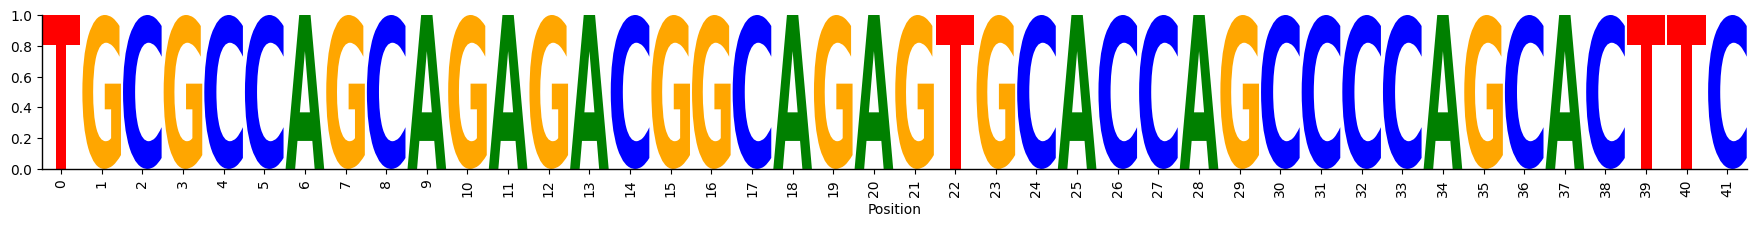

In [18]:
logo = logomaker.Logo(original_1_seq.iloc[:42,:], figsize=(22,2))

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')

logo.ax.set_ylabel('')
logo.ax.set_xlabel('Position')
plt.savefig("/home/seri9148/seyeon_project/TCR_generation/ddpm_neo_valid/original_1_seq.png", dpi=300, bbox_inches='tight')
logo.fig.show()

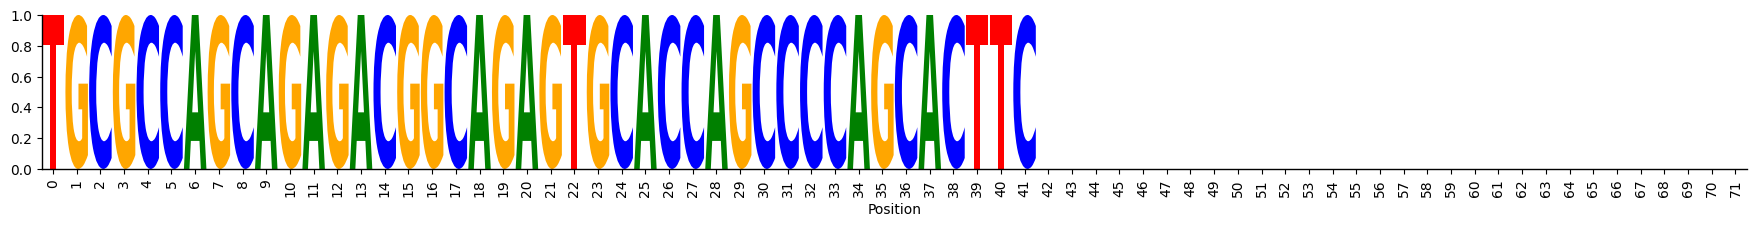

In [19]:
logo = logomaker.Logo(original_1_seq, figsize=(22,2))

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')

logo.ax.set_ylabel('')
logo.ax.set_xlabel('Position')
logo.fig.show()

In [20]:
# amino
original_amino = acid_to_amino(original_1_seq)

In [21]:
original_amino

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.


findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Fon

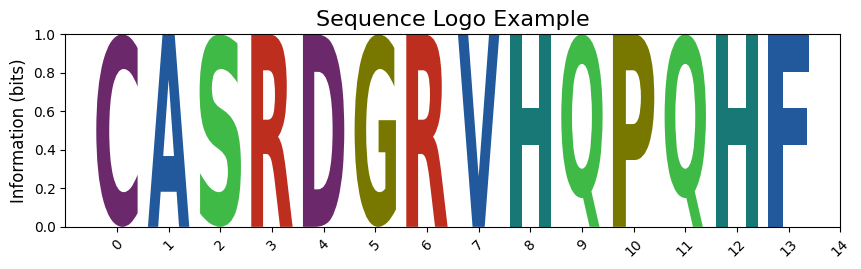

In [ ]:
# Logo
ww_logo = logomaker.Logo(original_amino,
                         font_name='Stencil Std',
                         color_scheme='NajafabadiEtAl2017',
                         #vpad=0.1,  # 수직 패딩
                         width=0.8)  # 막대 너비

ww_logo.style_xticks(anchor=0, spacing=1, rotation=45)  # X axis
# ww_logo.highlight_position(p=1, color='gold', alpha=0.5)   
# ww_logo.highlight_position(p=3, color='gold', alpha=0.5) 

# Axes
ww_logo.ax.set_ylabel('Information (bits)', fontsize=12)  # Y axis
ww_logo.ax.set_xlim([-1, 14])  # X축 범위 설정
ww_logo.ax.set_title("Sequence Logo Example", fontsize=16)
ww_logo.fig.savefig("/original_1_amino.png", dpi=300, bbox_inches='tight')

### denoised TCR

In [23]:
denoised_TCR_1 = denoised_TCR[3][3].cpu().detach().tolist()

denoised_TCR_1_seq = pd.DataFrame({"A" : denoised_TCR_1[0],
                                    "T" : denoised_TCR_1[1],
                                    "G" : denoised_TCR_1[2],
                                    "C" : denoised_TCR_1[3]})

In [24]:
denoised_TCR_1_seq

,A,T,G,C
0,-0.062338,0.933626,0.021746,0.074873
1,-0.017186,0.036280,0.815059,0.074248
2,-0.028164,0.047207,0.021073,0.858847
3,-0.044178,0.030386,0.832686,0.053495
4,-0.020406,0.038374,0.027955,0.825177
...,...,...,...,...
67,-0.013572,0.036711,0.066759,0.061767
68,-0.013590,0.036145,0.068561,0.061582
69,-0.010055,0.038716,0.069825,0.065159
70,-0.012967,0.038032,0.073092,0.071325


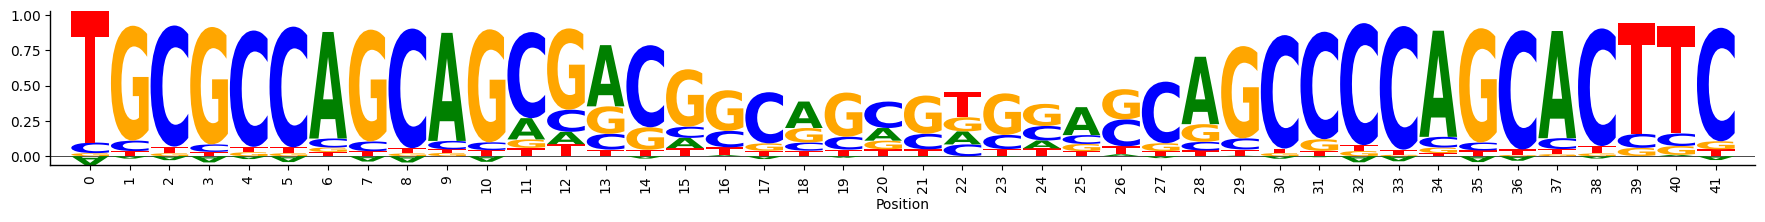

In [25]:
logo = logomaker.Logo(denoised_TCR_1_seq.iloc[:42,:], figsize=(22,2))

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')

logo.ax.set_ylabel('')
logo.ax.set_xlabel('Position')
logo.ax.set_xlim([-1, 42])
plt.savefig("/home/seri9148/seyeon_project/TCR_generation/ddpm_neo_valid/generated_1_seq.png", dpi=300, bbox_inches='tight')
logo.fig.show()

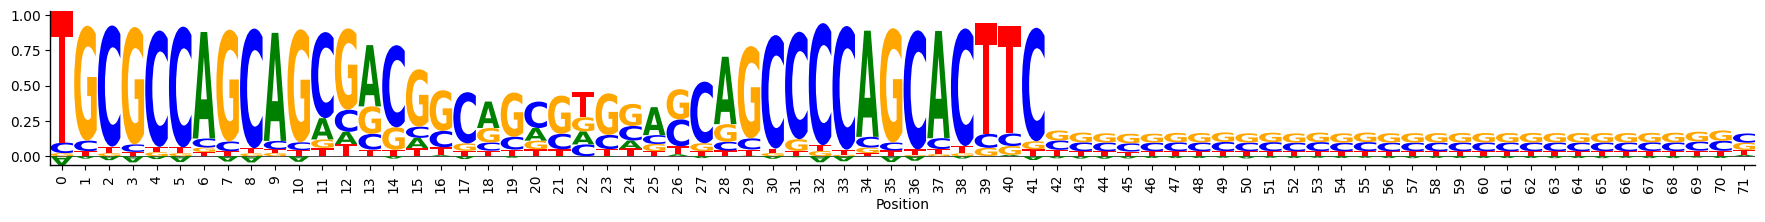

In [26]:
logo = logomaker.Logo(denoised_TCR_1_seq, figsize=(22,2))

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')

logo.ax.set_ylabel('')
logo.ax.set_xlabel('Position')
logo.fig.show()

In [27]:
denoisy_TCR_amino = generated_TCR_amino(denoised_TCR_1_seq)

findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.


findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Fon

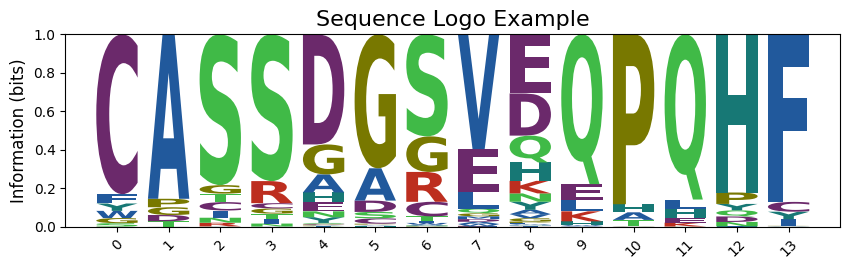

In [ ]:
ww_logo = logomaker.Logo(denoisy_TCR_amino.iloc[:14, :],
                         font_name='Stencil Std', 
                         color_scheme='NajafabadiEtAl2017', 
                         #vpad=0.1,  
                         width=0.8)  

# Logo
ww_logo.style_xticks(anchor=0, spacing=1, rotation=45) 
# ww_logo.highlight_position(p=1, color='gold', alpha=0.5)
# ww_logo.highlight_position(p=3, color='gold', alpha=0.5) 

# Axes
ww_logo.ax.set_ylabel('Information (bits)', fontsize=12)
ww_logo.ax.set_xlim([-1, 14])
ww_logo.ax.set_title("Sequence Logo Example", fontsize=16)
ww_logo.fig.savefig("/generated_2_amino.png", dpi=300, bbox_inches='tight')

### corr

In [ ]:
def corr(data1, data2):
    correlations = []
    for idx in range(data1.shape[0]):
        row1 = data1.iloc[idx]
        row2 = data2.iloc[idx]
        
        corr, _ = pearsonr(row1, row2)
        correlations.append(corr)

    correlation_df = pd.DataFrame(correlations, columns=["Pearson Correlation"], index=[f"Row {i}" for i in range(data1.shape[0])])
    
    return correlations

/home/seri9148/anaconda3/envs/deeplearning/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


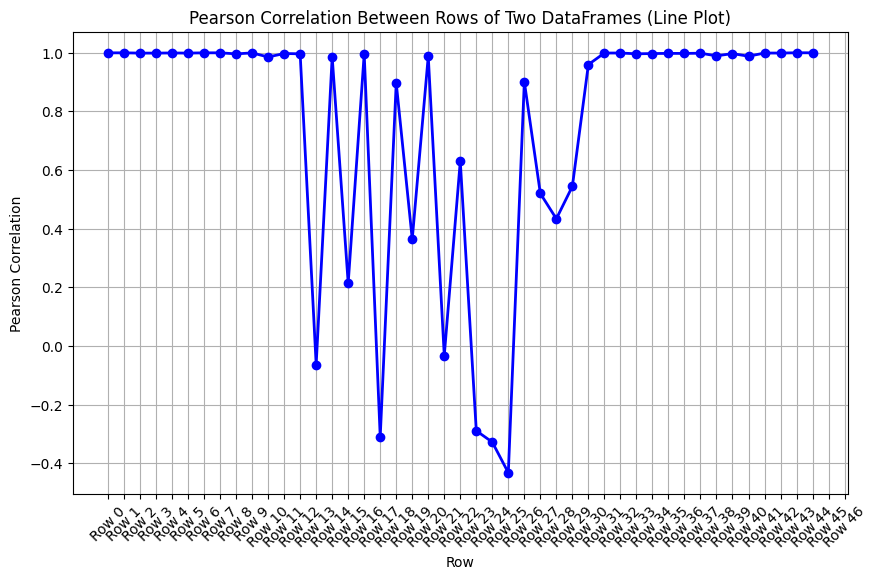

In [ ]:
corr_1 = corr(original_1_seq, denoised_TCR_1_seq)

plt.figure(figsize=(10, 6))
plt.plot(corr_1.index, corr_1['Pearson Correlation'], marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Pearson Correlation Between Rows of Two DataFrames (Line Plot)')
plt.xlabel('Row')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

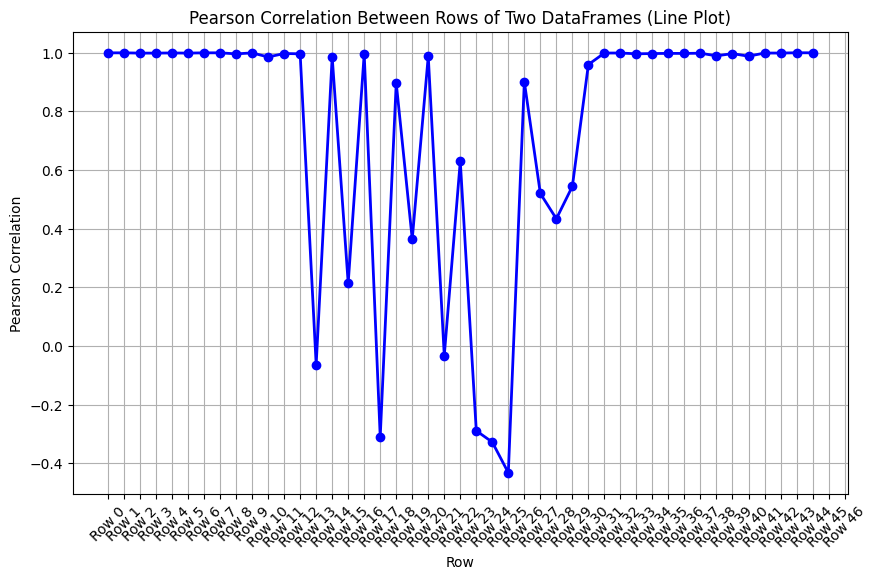

In [ ]:
correlations = []
for idx in range(original_1_seq.shape[0]):
    row1 = original_1_seq.iloc[idx]
    row2 = denoised_TCR_1_seq.iloc[idx]
    
    corr, _ = pearsonr(row1, row2)
    correlations.append(corr)

correlation_df = pd.DataFrame(correlations, columns=["Pearson Correlation"], index=[f"Row {i}" for i in range(original_1_seq.shape[0])])

plt.figure(figsize=(10, 6))
plt.plot(correlation_df.index, correlation_df['Pearson Correlation'], marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Pearson Correlation Between Rows of Two DataFrames (Line Plot)')
plt.xlabel('Row')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/home/seri9148/anaconda3/envs/deeplearning/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


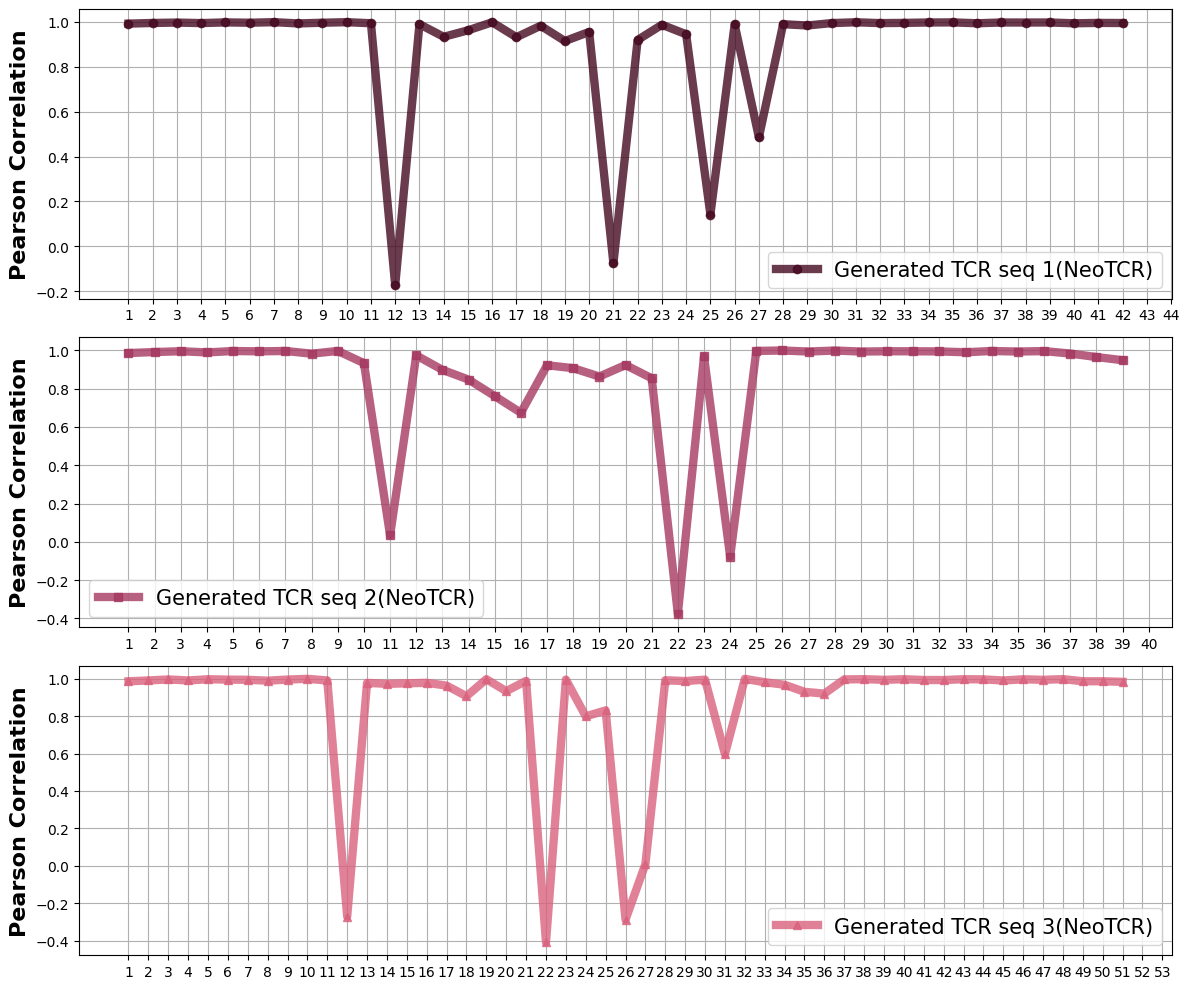

In [ ]:
corr_1 = corr(original_1_seq, denoised_TCR_1_seq)
corr_2 = corr(original_2_seq, denoised_TCR_2_seq)
corr_3 = corr(original_3_seq, denoised_TCR_3_seq)

x_labels = [f"{i+1}" for i in range(len(corr_3))]

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].plot(x_labels, corr_1, marker='o', label='Generated TCR seq 1(NeoTCR)', color='#450920', linewidth=6, alpha = 0.8)
axs[0].set_title('')
axs[0].set_xlabel('')
axs[0].set_ylabel('Pearson Correlation', fontsize=16, fontweight='bold')
axs[0].grid(True)
axs[0].legend(fontsize=15)


axs[1].plot(x_labels, corr_2, marker='s', label='Generated TCR seq 2(NeoTCR)', color='#a53860', linewidth=6, alpha = 0.8)
axs[1].set_title('')
axs[1].set_xlabel('')
axs[1].set_ylabel('Pearson Correlation', fontsize=16, fontweight='bold')
axs[1].grid(True)
axs[1].legend(fontsize=15)

axs[2].plot(x_labels, corr_3, marker='^', label='Generated TCR seq 3(NeoTCR)', color='#da627d', linewidth=6, alpha = 0.8)
axs[2].set_title('')
axs[2].set_xlabel('')
axs[2].set_ylabel('Pearson Correlation', fontsize=16, fontweight='bold')
axs[2].grid(True)
axs[2].legend(fontsize=15)

plt.tight_layout()
plt.savefig("/home/seri9148/seyeon_project/TCR_generation/ddpm_neo_valid/TCR_correlation_plot.png", dpi=300, bbox_inches='tight')
plt.show()